А в разделе 6.3 мы пытаемся прогнозировать погоду на основе исторических данных с использованием продвинутых подходов в RNN.
Получение и подготовка данных, генератор для извлечения образцов и ответов из временного ряда, базовое решение без ML.
Решение на полносвязной сети, решение на GRU(лучший результат), продвинутые улучшения (без улучшения результата). Узнали что RNN работают очень долго и требуют овердохуя ресурсов (сократил количество эпох до 7-10, но это все равно многие гигабайты памяти и многие часы обучения).

In [2]:
import os

data_dir = 'D:\data\deeplearningpython\Ch6_3\jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
from matplotlib import pyplot as plt
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.figure()
plt.plot(range(1440), temp[:1440])

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.2897359729905486


In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Using TensorFlow backend.









Epoch 1/20





500/500 [==============================] - 16s 32ms/step - loss: 1.2903 - val_loss: 0.5656
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3976 - val_loss: 0.3297
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2854 - val_loss: 0.3085
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2622 - val_loss: 0.2985
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2496 - val_loss: 0.3146
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2396 - val_loss: 0.3256
Epoch 7/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2325 - val_loss: 0.3435
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2278 - val_loss: 0.3295
Epoch 9/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2230 - val_loss: 0.3111
Epoch 10/20
500/500 [==============================] - 15s 31ms/step -

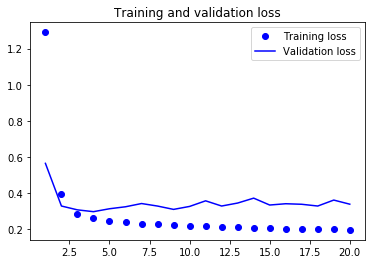

In [13]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=10, validation_data=val_gen, validation_steps=val_steps)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





500/500 [==============================] - 193s 386ms/step - loss: 0.3013 - val_loss: 0.2815
Epoch 2/10
500/500 [==============================] - 236s 473ms/step - loss: 0.2835 - val_loss: 0.2690
Epoch 3/10
500/500 [==============================] - 223s 445ms/step - loss: 0.2753 - val_loss: 0.2644
Epoch 4/10
500/500 [==============================] - 383s 767ms/step - loss: 0.2719 - val_loss: 0.2675
Epoch 5/10
500/500 [==============================] - 365s 730ms/step - loss: 0.2679 - val_loss: 0.2644
Epoch 6/10
500/500 [==============================] - 250s 499ms/step - loss: 0.2642 - val_loss: 0.2634
Epoch 7/10
500/500 [==============================] - 284s 568ms/step - loss: 0.2606 - val_loss: 0.2677
Epoch 8/10
500/500 [==============================] - 184s 368ms/step - loss: 0.2582 - val_loss: 0.2686
Epoch 9/10
500/500 [==============================] - 187s 374m

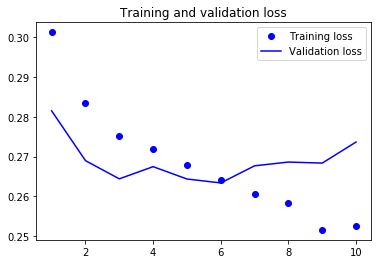

In [9]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=10, validation_data=val_gen, validation_steps=val_steps)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





500/500 [==============================] - 201s 401ms/step - loss: 0.3364 - val_loss: 0.2768
Epoch 2/10
500/500 [==============================] - 221s 441ms/step - loss: 0.3151 - val_loss: 0.2723
Epoch 3/10
500/500 [==============================] - 220s 440ms/step - loss: 0.3097 - val_loss: 0.2725
Epoch 4/10
500/500 [==============================] - 370s 740ms/step - loss: 0.3047 - val_loss: 0.2699
Epoch 5/10
500/500 [==============================] - 229s 459ms/step - loss: 0.3032 - val_loss: 0.2682
Epoch 6/10
500/500 [==============================] - 303s 606ms/step - loss: 0.2983 - val_loss: 0.2757
Epoch 7/10
500/500 [==============================] - 303s 607ms/step - loss: 0.2975 - val_loss: 0.2670
Epoch 8/10
500/500 [==============================]

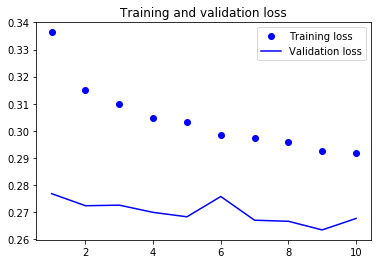

In [9]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=7, validation_data=val_gen, validation_steps=val_steps)

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/7





500/500 [==============================] - 357s 714ms/step - loss: 0.3336 - val_loss: 0.2871
Epoch 2/7
500/500 [==============================] - 458s 917ms/step - loss: 0.3125 - val_loss: 0.2773
Epoch 3/7
500/500 [==============================] - 657s 1s/step - loss: 0.3063 - val_loss: 0.2742
Epoch 4/7
500/500 [==============================] - 915s 2s/step - loss: 0.3017 - val_loss: 0.2731
Epoch 5/7
500/500 [==============================] - 1235s 2s/step - loss: 0.2979 - val_loss: 0.2720
Epoch 6/7
500/500 [==============================] - 1683s 3s/step - loss: 0.2962 - val_loss: 0.2695
Epoch 7/7
500/500 [==============================] - 2157s 4s/step - loss: 0.2924 - val_loss: 0.2698


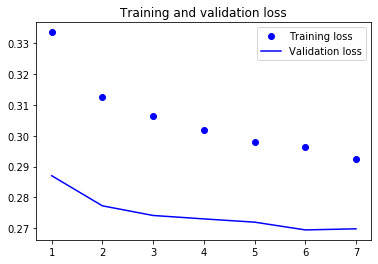

In [8]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

import numpy as np
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
np.load = np_load_old

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 20000 samples, validate on 5000 samples
Epoch 1/10





20000/20000 [==============================] - 229s 11ms/step - loss: 0.4929 - acc: 0.7655 - val_loss: 0.4237 - val_acc: 0.8334
Epoch 2/10
20000/20000 [==============================] - 241s 12ms/step - loss: 0.3193 - acc: 0.8784 - val_loss: 0.4859 - val_acc: 0.7966
Epoch 3/10
20000/20000 [==============================] - 239s 12ms/step - loss: 0.2595 - acc: 0.9055 - val_loss: 0.3380 - val_acc: 0.8594
Epoch 4/10
20000/20000 [==============================] - 262s 13ms/step - loss: 0.2237 - acc: 0.9200 - val_loss: 0.4114 - val_acc: 0.8648
Epoch 5/10
20000/20000 [==============================] - 239s 12ms/step - loss: 0.1952 - acc: 0.9334 - val_loss: 0.3736 - val_acc: 0.8770
Epoch 6/10
20000/20000 [==============================] - 251s 13ms/step - loss: 0.1753 - acc: 0.9380 - val_loss: 0.3643 - val_acc: 0.8794
Epoch 7/10

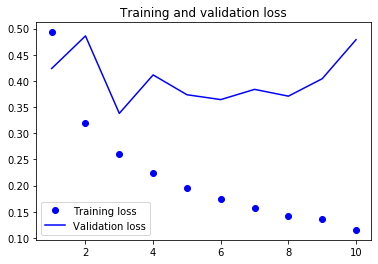

In [9]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

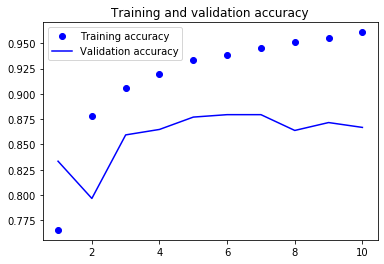

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [8]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

import numpy as np
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
np.load = np_load_old

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=7, batch_size=128, validation_split=0.2)

Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 20000 samples, validate on 5000 samples
Epoch 1/7





20000/20000 [==============================] - 122s 6ms/step - loss: 0.5356 - acc: 0.7337 - val_loss: 0.4817 - val_acc: 0.7960
Epoch 2/7
20000/20000 [==============================] - 138s 7ms/step - loss: 0.3249 - acc: 0.8769 - val_loss: 0.2940 - val_acc: 0.8840
Epoch 3/7
20000/20000 [==============================] - 202s 10ms/step - loss: 0.2555 - acc: 0.9057 - val_loss: 0.3175 - val_acc: 0.8832
Epoch 4/7
20000/20000 [==============================] - 244s 12ms/step - loss: 0.2287 - acc: 0.9170 - val_loss: 0.3209 - val_acc: 0.8700
Epoch 5/7
20000/20000 [==============================] - 316s 16ms/step - loss: 0.2056 - acc: 0.9281 - val_loss: 0.3266 - val_acc: 0.8872
Epoch 6/7
20000/20000 [==============================] - 396s 20ms/step - loss: 0.1812 - acc: 0.9359 - val_loss: 0.4443 - val_acc: 0.8320
Epoch 7/7
20000/20

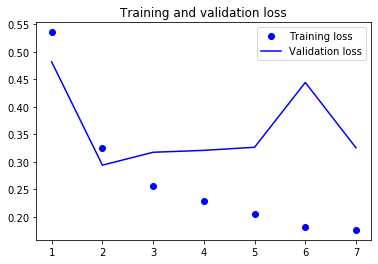

In [9]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

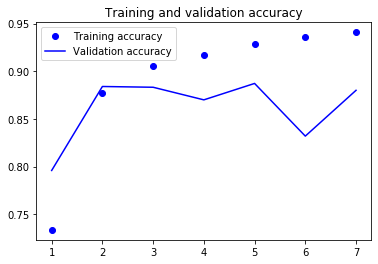

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=7, validation_data=val_gen, validation_steps=val_steps)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/7





500/500 [==============================] - 279s 558ms/step - loss: 0.2972 - val_loss: 0.2660
Epoch 2/7
500/500 [==============================] - 262s 525ms/step - loss: 0.2759 - val_loss: 0.2609
Epoch 3/7
500/500 [==============================] - 302s 604ms/step - loss: 0.2672 - val_loss: 0.2674
Epoch 4/7
500/500 [==============================] - 282s 564ms/step - loss: 0.2601 - val_loss: 0.2627
Epoch 5/7
500/500 [==============================] - 275s 550ms/step - loss: 0.2524 - val_loss: 0.2717
Epoch 6/7
500/500 [==============================] - 280s 559ms/step - loss: 0.2450 - val_loss: 0.2714
Epoch 7/7
500/500 [==============================] - 333s 666ms/step - loss: 0.2388 - val_loss: 0.2726


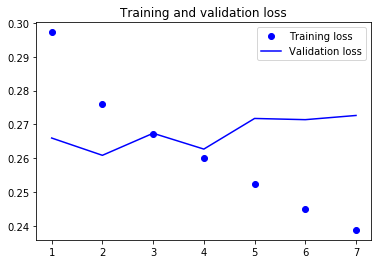

In [9]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()